# Reportes de deforestación 

Este código elabora reportes de deforestación de los predios considerados en el esquema PSAH de la Secretaría Distrital de Ambiente.

In [23]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as ctx
import geopandas as gpd
from shapely.geometry import mapping, box
import os
import rasterio
from rasterstats import zonal_stats
import tempfile
from docx import Document
from docx.shared import Inches, Pt
from docx.enum.table import WD_TABLE_ALIGNMENT
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx2pdf import convert
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import math
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.font_manager as fm
import os, re, tempfile, shutil, unicodedata
import pythoncom
import win32com.client as win32
from win32com.client import Dispatch
from matplotlib.patches import FancyArrow, Polygon


ModuleNotFoundError: No module named 'exceptions'

In [6]:
pip install exceptions

ERROR: Could not find a version that satisfies the requirement exceptions (from versions: none)
ERROR: No matching distribution found for exceptions
Note: you may need to restart the kernel to use updated packages.


In [16]:
from dotenv import load_dotenv
load_dotenv()

True

In [35]:
import metodos_mixtos as mmc
# from metodos_mixtos import importaciones_mapas import *
from metodos_mixtos import mapas
from metodos_mixtos import mapas_raster

## Cargar datos

In [18]:
# La carpeta original está en: 
#r"C:\Users\laura\OneDrive\Documents\GitHub\Bosques_Bogotá_Nuevo\bosques-bog\deforestation_reports"
#Agregar enlace de OneDrive
deforestacion_data_path = os.getenv('ONEDRIVE_DATA_DEFORESTACION_PATH')

In [19]:
psah_path = os.path.join(deforestacion_data_path, "Shapes PSA/areas_priorizadas_psah.shp")
psah= gpd.read_file(psah_path)

In [22]:
aoi_path = os.getenv('ONEDRIVE_AOI_PATH')
print(aoi_path)
aoi= gpd.read_file(aoi_path)

None


DataSourceError: None: No such file or directory

In [39]:
psah = psah.to_crs(epsg=4326) 
aoi=aoi.to_crs(epsg=4326)

<Axes: >

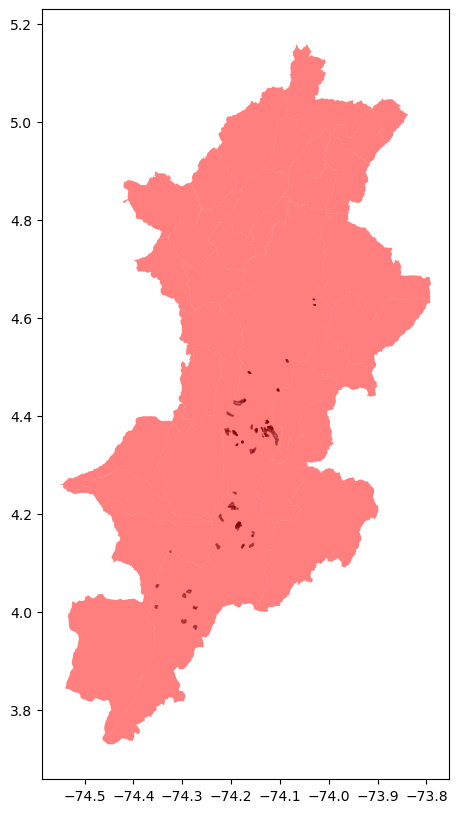

In [40]:
plot = psah.plot(figsize=(10, 10), edgecolor='black', alpha=0.5)
aoi.plot(ax=plot, color='red', alpha=0.5)

In [41]:
psah.head()

,OBJECTID,lotCodigo,ID,PreDirecc,Tipo_Area,Estado,Area_ha,Obs,Shape_Leng,Shape_Area,geometry
0,9.0,102909000022,085,MONTE BELLO- SAN BENITO,1,1,156.030179,None,10812.067744,1.558391e+06,"POLYGON ((-74.11192 4.36883, -74.11177 4.36872..."
1,18.0,102910000026,140,VDA CENTRO PIEDRA GRANDE ARRAYAN,1,1,0.277688,None,580.102470,2.773522e+03,"MULTIPOLYGON (((-74.13519 4.35873, -74.13511 4..."
2,35.0,102910000026,140,VDA CENTRO PIEDRA GRANDE ARRAYAN,1,1,0.174623,None,288.936418,1.744118e+03,"POLYGON ((-74.13351 4.35802, -74.1335 4.35806,..."
3,37.0,102909000005,203,MICANIA II-SAN BENITO,1,1,2.934480,EUCALIPTOS AISLADOS,1272.100361,2.930926e+04,"POLYGON ((-74.13102 4.37005, -74.131 4.37007, ..."
4,40.0,102909000005,203,MICANIA II-SAN BENITO,1,1,0.597814,None,740.669831,5.970918e+03,"POLYGON ((-74.13442 4.36961, -74.13441 4.36958..."


<Axes: >

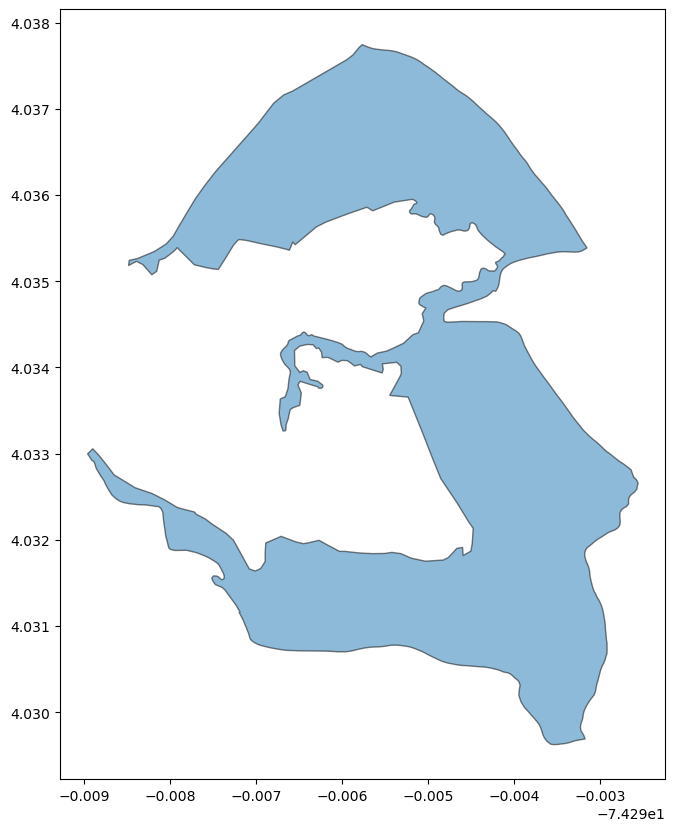

In [42]:
id1=psah[psah["lotCodigo"] == "109103000027"]
id1.plot(figsize=(10, 10), edgecolor='black', alpha=0.5)

In [43]:
id1.to_file(os.path.join(carpeta_reportesdef, r"output\psah_lote_109103000027.kml"), driver="KML")

### Cortar ráster

In [44]:
mapas_raster.raster_clipping(os.path.join(carpeta_reportesdef, r"data\AOI-Bogota-Colombia\bog-area-estudio.shp"), os.path.join(carpeta_reportesdef, r"data\Hansen Colombia 2024\hansen_treecover_Colombia_2024_mosaico.tif"),  os.path.join(carpeta_reportesdef, r"data\Hansen Colombia 2024\hansen_treecover_SDP_2024.tif"))

'C:\\Users\\laura\\OneDrive\\Documents\\GitHub\\Bosques_Bogotá_Nuevo\\bosques-bog\\deforestation_reports\\data\\Hansen Colombia 2024\\hansen_treecover_SDP_2024.tif'

## Parámetros

In [45]:
# Rutas de entrada
hansen_path = os.path.join(carpeta_reportesdef, r"data\Hansen Colombia 2024\hansen_treecover_SDP_2024.tif")

# Parámetros
nombre_columna = "lotCodigo"  # o "id" que sea único para el predio
año_inicio = 2000 # Año inicial de análisis
año_fin = 2024 # Año final de análisis
carpeta_salida = os.path.join(carpeta_reportesdef, "output")

## Funciones 

In [63]:
# Funciones para flecha norte y barra de escala


# Flecha del norte
def add_north_arrow(ax, xy=(0.1, 0.88), size=0.1, text="N",
                    color="black", lw=1.8):
    """
    Flecha del norte en la esquina superior izquierda (por defecto).
    - xy: base de la flecha (en fracción del eje)
    - size: largo de la flecha
    - text: etiqueta (default 'N')
    - color: color del texto y la flecha
    - lw: grosor de línea
    """
    # Texto "N" arriba de la flecha
    ax.text(xy[0], xy[1] + size + 0.02, text,
            transform=ax.transAxes, ha="center", va="bottom",
            fontsize=12, fontweight="bold", color=color, zorder=1000)

    # Flecha
    arr = FancyArrow(xy[0], xy[1], 0, size,
                     width=size*0.25, head_width=size*0.45, head_length=size*0.35,
                     length_includes_head=True, transform=ax.transAxes,
                     color=color, linewidth=lw, zorder=999)
    ax.add_patch(arr)


# Escala
def _pick_nice_length_km(width_km):
    """Elige un largo 'bonito' ~1/5 del ancho del AOI."""
    target = max(1, width_km/5)
    for nice in [1,2,5,10,20,25,50,100,200,250,500,1000]:
        if target <= nice:
            return nice
    return 1000

def _loc_xy0(ax, loc, pad_frac_x, pad_frac_y):
    """Devuelve esquina (x0,y0) según loc, en unidades de datos del eje."""
    X0, X1 = ax.get_xlim(); Y0, Y1 = ax.get_ylim()
    xpad = (X1 - X0) * pad_frac_x
    ypad = (Y1 - Y0) * pad_frac_y
    if loc == "lower right":
        return (X1 - xpad, Y0 + ypad)
    elif loc == "lower left":
        return (X0 + xpad, Y0 + ypad)
    elif loc == "upper right":
        return (X1 - xpad, Y1 - ypad)
    elif loc == "upper left":
        return (X0 + xpad, Y1 - ypad)
    else:
        return (X1 - xpad, Y0 + ypad)  # por defecto lower right

# Escala en lon/lat (EPSG:4326)
def add_scalebar_lonlat(ax, gdf_wgs, loc="lower right",
                        pad_frac=(0.06, 0.06), height_frac=0.012,
                        font=9, segments=2):
    """
    Barra de escala para mapas en WGS84 (grados). Aproxima metros/° por latitud.
    - loc: 'lower/upper left/right'
    - pad_frac: (x,y) margen como fracción del rango del eje
    - height_frac: alto de la barra como fracción del rango vertical
    - segments: bloques alternados (2 típico)
    """
    # Asegura 4326
    if gdf_wgs.crs is None:
        gdf_wgs = gdf_wgs.set_crs(4326)
    else:
        gdf_wgs = gdf_wgs.to_crs(4326)

    # Ancho del AOI en km (vía 3857 para tener métricas correctas)
    bounds_m = gdf_wgs.to_crs(3857).total_bounds
    width_km = (bounds_m[2] - bounds_m[0]) / 1000.0
    length_km = _pick_nice_length_km(width_km)

    # Metros por grado de longitud a la latitud central (por crs)
    cy = float(gdf_wgs.geometry.unary_union.centroid.y)
    meters_per_deg_lon = 111_320 * math.cos(math.radians(cy))
    deg_len = max(1e-9, (length_km * 1000) / max(1e-9, meters_per_deg_lon))

    # Posición base
    X0, X1 = ax.get_xlim(); Y0, Y1 = ax.get_ylim()
    x0_base, y0_base = _loc_xy0(ax, loc, pad_frac[0], pad_frac[1])

    # Ajuste según esquina (x0,y0)
    if "right" in loc:
        x0 = x0_base - deg_len
    else:
        x0 = x0_base
    if "upper" in loc:
        
        y0 = y0_base - (Y1 - Y0) * height_frac
    else:
        y0 = y0_base

    # Alto relativo
    height = (Y1 - Y0) * height_frac

    # Dibujar segmentos alternados
    seg_len = deg_len / max(1, segments)
    for i in range(segments):
        rect = mpatches.Rectangle(
            (x0 + i*seg_len, y0), seg_len, height,
            facecolor=("black" if i % 2 == 0 else "white"),
            edgecolor="black", linewidth=0.8, zorder=6
        )
        ax.add_patch(rect)

    # Etiqueta
    ax.text(x0 + deg_len/2, y0 + height*1.35, f"{int(length_km)} km",
            ha="center", va="bottom", fontsize=font, color="black",
            bbox=dict(facecolor="white", edgecolor="0.8", alpha=0.85, pad=1.2),
            zorder=7)

# Escala en metros (crs 3857)
def add_scalebar_meter(ax, gdf_m, loc="lower right",
                       pad_frac=(0.05, 0.05), height_frac=0.012,
                       font=10, segments=2):
    """
    Barra de escala para CRS en metros (UTM/3857).
    - height_frac: alto relativo al rango Y del eje (robusto a cambios de zoom)
    """
    # Se asume crs en metros
    xmin, ymin, xmax, ymax = gdf_m.total_bounds
    width_km = (xmax - xmin)/1000.0
    length_km = _pick_nice_length_km(width_km)
    length_m  = length_km * 1000.0

    # Posición base
    X0, X1 = ax.get_xlim(); Y0, Y1 = ax.get_ylim()
    x0_base, y0_base = _loc_xy0(ax, loc, pad_frac[0], pad_frac[1])

    
    if "right" in loc:
        x0 = x0_base - length_m
    else:
        x0 = x0_base
    if "upper" in loc:
        y0 = y0_base - (Y1 - Y0) * height_frac
    else:
        y0 = y0_base

    # Alto relativo
    height = (Y1 - Y0) * height_frac

    # Segmentos
    seg_len = length_m / max(1, segments)
    for i in range(segments):
        rect = mpatches.Rectangle(
            (x0 + i*seg_len, y0), seg_len, height,
            facecolor=("black" if i % 2 == 0 else "white"),
            edgecolor="black", linewidth=0.8, zorder=6
        )
        ax.add_patch(rect)

    # Etiqueta
    label = f"{int(length_km)} km" if length_km >= 1 else f"{int(length_m)} m"
    ax.text(x0 + length_m/2, y0 + height*1.35, label,
            ha="center", va="bottom", fontsize=font, color="black",
            bbox=dict(facecolor="white", edgecolor="0.8", alpha=0.85, pad=1.2),
            zorder=7)

# Fuente del basemap
def add_attribution(ax, text, fontsize=6, alpha=0.6, loc="lower left", pad=0.01):
    """
    Texto pequeño para la fuente del basemap en fracción del eje.
    """
    x = pad if "left" in loc else 1 - pad
    y = pad if "lower" in loc else 1 - pad
    ax.text(x, y, text, transform=ax.transAxes,
            ha=("left" if "left" in loc else "right"),
            va=("bottom" if "lower" in loc else "top"),
            fontsize=fontsize, color="0.2",
            bbox=dict(facecolor="white", alpha=alpha, edgecolor="none",
                      boxstyle="round,pad=0.15"),
            zorder=2000)



In [64]:
# Mapa de deforestación por lote

def plot_deforestation_map(
    raster_path, gdf, names_column, name_of_area,
    year_start, year_end, output_folder=".", basemap=False
):
    safe_name = str(name_of_area).replace(" ", "_").replace("/", "_")
    output_path = os.path.join(output_folder, f"deforestacion_{safe_name}_{year_start}_a_{year_end}.png")

    temp_dir = tempfile.mkdtemp()
    temp_shp = os.path.join(temp_dir, "temp_shape.shp")
    temp_tif = os.path.join(temp_dir, "temp_raster_clip.tif")
    gdf.to_file(temp_shp)
    mapas_raster.raster_clipping(temp_shp, raster_path, temp_tif)

    with rasterio.open(temp_tif) as src:
        raster_crs = src.crs
        if gdf.crs != raster_crs: gdf = gdf.to_crs(raster_crs)

        band_count = src.count
        start_code = year_start - 2000
        end_code = year_end - 2000

        if band_count == 1:
            lossyear = src.read(1)
            loss_mask = ((lossyear >= start_code) & (lossyear <= end_code)).astype(np.uint8) * 255
            preserved_mask = (lossyear == 0).astype(np.uint8) * 255
        elif band_count >= 3:
            treecover2000 = src.read(1); loss = src.read(2); lossyear = src.read(3)
            valid_forest = treecover2000 > 0
            loss_mask = (valid_forest & (loss == 1) & (lossyear >= start_code) & (lossyear <= end_code)).astype(np.uint8) * 255
            preserved_mask = (valid_forest & ((loss == 0) | (lossyear > end_code))).astype(np.uint8) * 255
        else:
            raise ValueError("El raster debe tener 1 banda o 3 bandas Hansen.")

        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # --- PLOT ---
    # ANTES
    fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)

    ax.imshow(preserved_mask, cmap='Greens', extent=extent)
    ax.imshow(loss_mask, cmap='Reds',   extent=extent, alpha=0.6)

    gdf.boundary.plot(ax=ax, color='black', linewidth=1)
    for _, row in gdf.iterrows():
        c = row.geometry.centroid
        ax.annotate(text=str(row.get(names_column, "")), xy=(c.x, c.y), ha='center', fontsize=5, color='black')

    legend1 = mpatches.Patch(color='green', label=f'Bosque en {year_end}')
    legend2 = mpatches.Patch(color='red',   label=f'Pérdida {year_start}–{year_end}')
    ax.legend(handles=[legend1, legend2], loc='upper right', frameon=True)

    ax.set_title(f'Pérdida de bosque entre {year_start} y {year_end} en {name_of_area}')
    ax.set_xticks([]); ax.set_yticks([])

    DEF_BUFFER = 0.35  
    xmin, ymin, xmax, ymax = gdf.total_bounds
    dx = (xmax - xmin) * DEF_BUFFER; dy = (ymax - ymin) * DEF_BUFFER
    ax.set_xlim(xmin - dx, xmax + dx)
    ax.set_ylim(ymin - dy, ymax + dy)

   
    add_north_arrow(ax, xy=(0.07, 0.85), size=0.05, color="black")


    # Escala abajo-derecha en crs 4326. Si tu raster está en 3857, usa add_scalebar_meter.
    gdf_wgs = gdf.to_crs(4326) if (gdf.crs and gdf.crs.to_epsg() != 4326) else gdf
    add_scalebar_lonlat(ax, gdf_wgs=gdf_wgs, loc="lower right", segments=2)
    add_attribution(ax, "Fuente: Hansen Global Forest Change 2024",
                fontsize=10, loc="lower left")


    plt.savefig(output_path, bbox_inches='tight', dpi=400)
    plt.close()
    print(f"Mapa guardado en: {output_path}")
    return output_path

In [47]:
# Cálculo de deforestación anual por polígono en formato tabla (se calcula en ha)
def def_anual(gdf, raster_path, year_min=2000, year_max=2024):
    """
    Calcula la deforestación anual en hectáreas (ha) por polígono
    usando Hansen multibanda y recorte previo.
    """
    # Códigos Hansen
    start_code = year_min - 2000
    end_code = year_max - 2000

    # Archivos temporales
    temp_dir = tempfile.mkdtemp()
    temp_shp = os.path.join(temp_dir, "temp_shape.shp")
    temp_tif = os.path.join(temp_dir, "temp_raster_clip.tif")
    gdf.to_file(temp_shp)

    # Recorte del raster
    mapas_raster.raster_clipping(temp_shp, raster_path, temp_tif)

    # Leer y filtrar raster
    with rasterio.open(temp_tif) as src:
        treecover2000 = src.read(1)
        loss = src.read(2)
        lossyear = src.read(3)

        # Máscara de pérdida válida
        mask_loss = (
            (treecover2000 > 0) &
            (loss == 1) &
            (lossyear >= start_code) &
            (lossyear <= end_code)
        )

        lossyear_masked = np.where(mask_loss, lossyear, 0)

        # Guardar el profile aquí dentro del with
        profile = src.profile

    # Guardar raster filtrado
    profile.update(dtype=rasterio.uint8, count=1)
    temp_filtered = os.path.join(temp_dir, "filtered_lossyear.tif")
    with rasterio.open(temp_filtered, "w", **profile) as dst:
        dst.write(lossyear_masked.astype(rasterio.uint8), 1)

    # Calcular estadísticas zonales por año
    stats = zonal_stats(
        gdf, temp_filtered,
        stats=['count'],
        categorical=True,
        nodata=0
    )

    results = []
    for i, stat in enumerate(stats):
        for year_code, pixel_count in stat.items():
            if isinstance(year_code, int) and year_code > 0:
                year = 2000 + year_code
                area_ha = pixel_count * (30 * 30) / 10000
                results.append({
                    'id': gdf.iloc[i].get('id', i),
                    'year': year,
                    'deforestation_ha': area_ha
                })

    df_result = pd.DataFrame(results)

    # Mensaje si no hay deforestación detectada
    if df_result.empty or df_result["deforestation_ha"].sum() == 0:
        print("⚠ No se detectó deforestación en el rango de años especificado.")

    return df_result


In [48]:
# Leer raster y obtener CRS
with rasterio.open(hansen_path) as src:
    raster_crs = src.crs

print(f"CRS del raster: {raster_crs}")

CRS del raster: EPSG:4326


In [49]:
print(f"CRS del polígono: {psah.crs}")

CRS del polígono: EPSG:4326


In [51]:
plot_deforestation_map(
    raster_path=hansen_path,
    gdf=id1,
    names_column="lotCodigo",
    name_of_area=id1["PreDirecc"].iloc[0],
    year_start=año_inicio,
    year_end=año_fin,
    output_folder=os.path.join(carpeta_reportesdef, "output\Mapas\Mapas_deforestación")
)


<>:8: SyntaxWarning: invalid escape sequence '\M'
<>:8: SyntaxWarning: invalid escape sequence '\M'
C:\Users\laura\AppData\Local\Temp\ipykernel_11568\2379358178.py:8: SyntaxWarning: invalid escape sequence '\M'
  output_folder=os.path.join(carpeta_reportesdef, "output\Mapas\Mapas_deforestación")


Mapa guardado en: C:\Users\laura\OneDrive\Documents\GitHub\Bosques_Bogotá_Nuevo\bosques-bog\deforestation_reports\output\Mapas\Mapas_deforestación\deforestacion_LA_ESPERANZA-LAS_VEGAS_2000_a_2024.png


'C:\\Users\\laura\\OneDrive\\Documents\\GitHub\\Bosques_Bogotá_Nuevo\\bosques-bog\\deforestation_reports\\output\\Mapas\\Mapas_deforestación\\deforestacion_LA_ESPERANZA-LAS_VEGAS_2000_a_2024.png'

In [52]:
def_anual(gdf=id1,
          raster_path=hansen_path,
          year_max=año_fin,
          year_min=año_inicio)

⚠ No se detectó deforestación en el rango de años especificado.


""


In [53]:
# Mapa de ubicación dentro del AOI (contexto geográfico, incluye lupa del polígono)

def plot_location_map(aoi_gdf, poly_gdf, output_path):
    # Proyección para basemap (metros)
    aoi_proj  = aoi_gdf.to_crs(epsg=3857)
    poly_proj = poly_gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
    aoi_proj.boundary.plot(ax=ax, color="white", linewidth=1)
    poly_proj.boundary.plot(ax=ax, color="red", linewidth=2)

    # Limites del AOI
    ax.set_xlim(aoi_proj.total_bounds[[0, 2]])
    ax.set_ylim(aoi_proj.total_bounds[[1, 3]])

    # Basemap (no incluye basemap en la lupa)
    ctx.add_basemap(ax, crs=3857, source=ctx.providers.Esri.WorldImagery, attribution=False)

    ax.set_title("Ubicación del lote", fontsize=12)
    ax.set_xticks([]); ax.set_yticks([])

    add_north_arrow(ax, xy=(0.07, 0.85), size=0.05, color="white")


    # Escala abajo-derecha en epsg=4326 . 
    add_scalebar_meter(ax, gdf_m=aoi_proj, loc="lower right", segments=3, font=9)
    add_attribution(ax, "Fuente: Google Satellite",
                fontsize=10, loc="lower left")


    # Lupa del polígono (sin basemap porque es muy pequeño)
    axins = inset_axes(ax, width="35%", height="35%", loc="lower left",
                       bbox_to_anchor=(0.05, 0.05, 0.9, 0.9),
                       bbox_transform=ax.transAxes, borderpad=1.2)
    xmin, ymin, xmax, ymax = poly_proj.total_bounds
    dx = (xmax - xmin) * 0.25 if xmax > xmin else 1000
    dy = (ymax - ymin) * 0.25 if ymax > ymin else 1000
    x0, x1 = xmin - dx, xmax + dx
    y0, y1 = ymin - dy, ymax + dy

    # No se toma el basemap en la lupa, pero se pone en fondo blanco
    axins.set_facecolor("white")
    aoi_proj.boundary.plot(ax=axins, color="#bbbbbb", linewidth=0.7)
    poly_proj.boundary.plot(ax=axins, color="red", linewidth=1.5)
    axins.set_xlim(x0, x1); axins.set_ylim(y0, y1)
    axins.set_xticks([]); axins.set_yticks([])

    mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.4", lw=0.8)

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches="tight")
    plt.close()


In [65]:
# Crear reporte (no incluye tabla de deforestación cuando no hay pérdida)

def crear_reporte(titulo, descripcion, tabla_def, img_context, img_deforestation, output_path):
    import re

    IMG_MAX_HEIGHT_IN = 4.0  # baja a 2.8 si aún ves saltos

    # ---- Helpers ----
    def _sum_ha(df: pd.DataFrame) -> float:
        """Suma la columna de hectáreas (detecta 'ha', 'hectáreas', etc.)."""
        if df is None or df.empty:
            return 0.0
        ha_cols = [c for c in df.columns if re.search(r'\bha\b|hect', str(c), re.I)]
        if not ha_cols:
            # fallback: primera numérica
            num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
            if not num_cols:
                return 0.0
            ha_col = num_cols[0]
        else:
            ha_col = ha_cols[0]
        return pd.to_numeric(df[ha_col], errors='coerce').fillna(0).sum()

    def _to_anual(df: pd.DataFrame) -> pd.DataFrame:
        """Normaliza a columnas ['Año','ha'] si viene con nombres diferentes."""
        if df is None or df.empty:
            return pd.DataFrame(columns=['Año', 'Hectáreas (ha)'])
        # detectar columnas
        ycol = None
        for c in df.columns:
            if re.search(r'a[ñn]o|anio|year|loss[_ ]?year', str(c), re.I):
                ycol = c; break
        ha_col = None
        for c in df.columns:
            if re.search(r'\bha\b|hect|area_?ha', str(c), re.I):
                ha_col = c; break
        out = df.copy()
        if ycol is not None and ha_col is not None:
            out = out.rename(columns={ycol: 'Año', ha_col: 'Hectáreas (ha)'})[['Año', 'Hectáreas (ha)']]
        else:
            # ancho: columnas con año en el nombre
            pairs = []
            for c in df.columns:
                m = re.search(r'(19|20)\d{2}', str(c))
                if m:
                    y = int(m.group(0))
                    v = pd.to_numeric(df[c], errors='coerce').fillna(0).sum()
                    pairs.append((y, v))
            out = pd.DataFrame(pairs, columns=['Año', 'Hectáreas (ha)']) if pairs else pd.DataFrame(columns=['Año','Hectáreas (ha)'])
        # limpiar tipos
        if not out.empty:
            out['Año'] = pd.to_numeric(out['Año'], errors='coerce').astype('Int64')
            out['Hectáreas (ha)']  = pd.to_numeric(out['Hectáreas (ha)'],  errors='coerce').fillna(0.0)
            out = out.dropna(subset=['Año']).astype({'Año':'int'}).groupby('Año', as_index=False)['Hectáreas (ha)'].sum()
            out = out.sort_values('Año')
        return out

    # Documento 
    doc = Document()
    section = doc.sections[0]
    section.page_width, section.page_height = Inches(8.5), Inches(11)
    section.left_margin = section.right_margin = section.top_margin = section.bottom_margin = Inches(0.75)

    normal = doc.styles['Normal'].paragraph_format
    normal.space_before = Pt(0); normal.space_after = Pt(6); normal.line_spacing = 1.08
    h1 = doc.styles['Heading 1'].paragraph_format; h1.space_before = Pt(0); h1.space_after = Pt(6)
    h2 = doc.styles['Heading 2'].paragraph_format; h2.space_before = Pt(8); h2.space_after = Pt(4); h2.keep_with_next = True

    # Título y descripción
    p = doc.add_heading(titulo, level=1); p.alignment = WD_ALIGN_PARAGRAPH.CENTER
    p = doc.add_paragraph(descripcion); p.alignment = WD_ALIGN_PARAGRAPH.JUSTIFY; p.paragraph_format.space_after = Pt(8)

    # Mapa de ubicación
    p = doc.add_heading("Mapa de ubicación", level=2); p.paragraph_format.keep_with_next = True
    pic = doc.add_paragraph(); run = pic.add_run(); run.add_picture(img_context, height=Inches(8))
    pic.alignment = WD_ALIGN_PARAGRAPH.CENTER; pic.paragraph_format.space_after = Pt(6)

    # Deforestación
    p = doc.add_heading("Deforestación", level=2); p.paragraph_format.keep_with_next = True

    # Si hay pérdida se muestra la tabla, si no, no se muestra la tabla
    hay_perdida = _sum_ha(tabla_def) > 0

    if hay_perdida:
        anual = _to_anual(tabla_def)
        subt = doc.add_heading("Deforestación anual (ha)", level=2); subt.paragraph_format.keep_with_next = True

        table = doc.add_table(rows=1, cols=2); table.style = "Table Grid"; table.alignment = WD_TABLE_ALIGNMENT.CENTER
        hdr = table.rows[0].cells; hdr[0].text = "Año"; hdr[1].text = "Hectáreas (ha)"
        for c in hdr:
            if c.paragraphs and c.paragraphs[0].runs: c.paragraphs[0].runs[0].bold = True
            c.paragraphs[0].paragraph_format.space_before = Pt(0); c.paragraphs[0].paragraph_format.space_after = Pt(0)

        for _, r in anual.iterrows():
            cells = table.add_row().cells
            cells[0].text = str(int(r['Año']))
            cells[1].text = f"{float(r['Hectáreas (ha)']):.2f}"
            for c in cells:
                pc = c.paragraphs[0]; pc.paragraph_format.space_before = Pt(0); pc.paragraph_format.space_after = Pt(0); pc.paragraph_format.keep_together = True

        # Espacio antes del mapa
        doc.add_paragraph().paragraph_format.space_after = Pt(4)
    else:
        p = doc.add_paragraph("No se detectó pérdida de cobertura arbórea en el rango de tiempo especificado.")
        p.paragraph_format.space_after = Pt(6)

    # Mapa de deforestación (siempre se incluye)
    p = doc.add_heading("Mapa de deforestación", level=2); p.paragraph_format.keep_with_next = True
    pic = doc.add_paragraph(); run = pic.add_run(); run.add_picture(img_deforestation, height=Inches(IMG_MAX_HEIGHT_IN))
    pic.alignment = WD_ALIGN_PARAGRAPH.CENTER; pic.paragraph_format.space_after = Pt(0)

    doc.save(output_path)


In [69]:
def _safe_ascii_name(name: str) -> str:
    import unicodedata, re
    n = unicodedata.normalize("NFKD", name)
    n = "".join(c for c in n if not unicodedata.combining(c))
    n = re.sub(r"[^A-Za-z0-9._-]+", "_", n).strip("_")
    return n

def convert_to_pdf_safe(docx_path: str) -> str:
    """
    Convierte DOCX->PDF con Word COM evitando gencache/EnsureDispatch (fuente del error MinorVersion).
    - Copia el DOCX a %TEMP% con nombre ASCII corto
    - Usa Dispatch("Word.Application") + CoInitialize
    """
    docx_path = os.path.abspath(docx_path)
    out_pdf = os.path.splitext(docx_path)[0] + ".pdf"

    # Copiar a TEMP con nombre simple
    tmpdir = tempfile.mkdtemp(prefix="docx2pdf_")
    safe_name = _safe_ascii_name(os.path.basename(docx_path))
    if not safe_name.lower().endswith(".docx"):
        safe_name += ".docx"
    temp_docx = os.path.join(tmpdir, safe_name)
    shutil.copyfile(docx_path, temp_docx)
    temp_pdf = os.path.splitext(temp_docx)[0] + ".pdf"

    wdExportFormatPDF = 17
    pythoncom.CoInitialize()
    word = None
    try:
        # 👉 Importante: NO usar win32.gencache.EnsureDispatch
        word = Dispatch("Word.Application")
        word.Visible = False
        word.DisplayAlerts = 0

        doc = word.Documents.Open(os.path.abspath(temp_docx))
        doc.ExportAsFixedFormat(os.path.abspath(temp_pdf), wdExportFormatPDF)
        doc.Close(False)
    finally:
        if word is not None:
            try:
                word.Quit()
            except Exception:
                pass
        pythoncom.CoUninitialize()

    shutil.move(temp_pdf, out_pdf)
    try:
        shutil.rmtree(tmpdir, ignore_errors=True)
    except Exception:
        pass
    return out_pdf


In [67]:
print(carpeta_salida)

C:\Users\laura\OneDrive\Documents\GitHub\Bosques_Bogotá_Nuevo\bosques-bog\deforestation_reports\output


C:\Users\laura\AppData\Local\Temp\ipykernel_11568\2182922267.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\laura\AppData\Local\Temp\ipykernel_11568\2182922267.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


⚠ No se detectó deforestación en el rango de años especificado.


C:\Users\laura\AppData\Local\Temp\ipykernel_11568\3030073616.py:76: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cy = float(gdf_wgs.geometry.unary_union.centroid.y)


Mapa guardado en: C:\Users\laura\OneDrive\Documents\GitHub\Bosques_Bogotá_Nuevo\bosques-bog\deforestation_reports\output\Mapas\Mapas_deforestación\deforestacion_MONTE_BELLO-_SAN_BENITO_2000_a_2024.png
✅ Reporte generado: C:\Users\laura\OneDrive\Documents\GitHub\Bosques_Bogotá_Nuevo\bosques-bog\deforestation_reports\output\reportes_deforestación\reporte_102909000022_2000_2024.pdf


C:\Users\laura\AppData\Local\Temp\ipykernel_11568\2182922267.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\laura\AppData\Local\Temp\ipykernel_11568\2182922267.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\laura\AppData\Local\Temp\ipykernel_11568\3030073616.py:76: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  cy = float(gdf_wgs.geometry.unary_union.centroid.y)


Mapa guardado en: C:\Users\laura\OneDrive\Documents\GitHub\Bosques_Bogotá_Nuevo\bosques-bog\deforestation_reports\output\Mapas\Mapas_deforestación\deforestacion_VDA_CENTRO_PIEDRA_GRANDE_ARRAYAN_2000_a_2024.png
✅ Reporte generado: C:\Users\laura\OneDrive\Documents\GitHub\Bosques_Bogotá_Nuevo\bosques-bog\deforestation_reports\output\reportes_deforestación\reporte_102910000026_2000_2024.pdf


C:\Users\laura\AppData\Local\Temp\ipykernel_11568\2182922267.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\laura\AppData\Local\Temp\ipykernel_11568\2182922267.py:50: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


KeyboardInterrupt: 

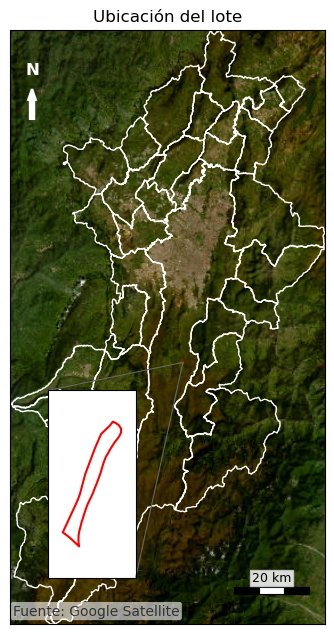

In [71]:

# Loop para recorrer todos los polígonos y generar reportes para cada uno de los predios

output_img = os.path.join(carpeta_salida, r"Mapas")

for idx, row in psah.iterrows():
    poly = gpd.GeoDataFrame([row], crs=psah.crs)
    nombre_area = row["PreDirecc"]

    # 1. Mapa de ubicación
    img_context_path = os.path.join(output_img,r"Mapas_contexto", f"ubicacion_{row['lotCodigo']}.png")
    plot_location_map(aoi, poly, img_context_path)

    # 2. Tabla de deforestación
    df_def = def_anual(poly, hansen_path, year_min=año_inicio, year_max=año_fin)

    # 3. Mapa de deforestación años seleccionados 
    img_def_path = plot_deforestation_map(
        hansen_path,
        poly,
        names_column="lotCodigo",
        name_of_area=nombre_area,
        year_start=año_inicio,
        year_end=año_fin,
        output_folder=os.path.join(output_img, "Mapas_deforestación"),
        basemap=True
    )

    # 4. Crear Word
    reporte_word = os.path.join(carpeta_salida,r"reportes_deforestación", f"reporte_{row['lotCodigo']}_{año_inicio}_{año_fin}.docx")
    crear_reporte(
        titulo=f"Reporte de deforestación para {nombre_area} de {año_inicio} a {año_fin}",
        descripcion=f"Este archivo contiene un monitoreo del área {nombre_area} (ID: {row['lotCodigo']}) en lo relacionado a pérdida de cobertura arbórea entre las fechas específicadas.",
        img_context=img_context_path,
        tabla_def=df_def,
        img_deforestation=img_def_path,  
        output_path=reporte_word
    )

    # Ruta esperada del PDF
    reporte_pdf =   convert_to_pdf_safe(reporte_word)

    print(f"✅ Reporte generado: {reporte_pdf}")
